In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import dask
import dask.array as da
from dask.graph_manipulation import clone
import numpy as np
from uuid import uuid4
from functools import partial

In [4]:
visualize_graph = partial(dask.visualize, node_attr={'penwidth': '4'}, optimize_graph=False)
visualize_order = partial(dask.visualize, node_attr={'penwidth': '4'}, optimize_graph=False, color='order', cmap='autumn')

In [5]:
IFrame(src="https://slides.com/jskenyon/deck-8a1a0e/embed", width=1700, height=800)

# Linear Chains

In [6]:
def linear_chains(nrow, nchan, row_chunks, chan_chunks): 

    row_chan_arr = da.zeros((nrow, nchan),
                            chunks=(row_chunks, chan_chunks),
                            name="row_chan-" + uuid4().hex)

    result_arr = da.blockwise(lambda x: x, "tf",
                              row_chan_arr, "tf",
                              dtype=np.float64,
                              concatenate=True,
                              align_arrays=False,
                              name="algorithm-" + uuid4().hex)

    return result_arr

In [7]:
example1 = linear_chains(10000, 64, 5000, 32)
example1

dask.array<algorithm, shape=(10000, 64), dtype=float64, chunksize=(5000, 32), chunktype=numpy.ndarray>

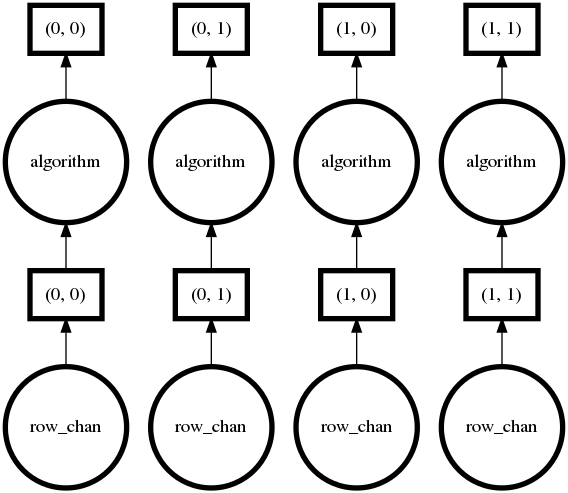

In [8]:
visualize_graph(example1)

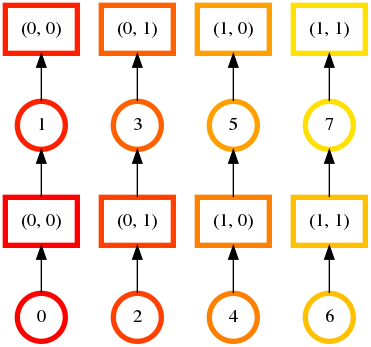

In [9]:
visualize_order(example1)

# Real-world Example - QuartiCal Solver

In [10]:
IFrame("./visualize_outputs/gain_graph.pdf", width=1720, height=480)

In [11]:
IFrame("./visualize_outputs/gain_order.pdf", width=1720, height=560)

<a id='sharedroots'></a>
# Shared Roots
Compare with the [version post cloning](#clonedroots).

In [12]:
def shared_root(nrow, nchan, row_chunks, chan_chunks, narray): 

    result_list = []
   
    chan_arr = da.zeros(nchan,
                        name="chan-" + uuid4().hex,
                        chunks=chan_chunks)

    for i in range(narray):
        row_chan_arr = da.zeros((nrow, nchan),
                                chunks=(row_chunks, chan_chunks),
                                name="row_chan-" + uuid4().hex)

        result_arr = da.blockwise(lambda x, y: x*y[None, :], "tf",
                                  row_chan_arr, "tf",
                                  chan_arr, "f",
                                  dtype=np.float64,
                                  concatenate=True,
                                  align_arrays=False,
                                  name="algorithm-" + uuid4().hex)
        
        result_list.append(result_arr)
    
    return result_list

In [13]:
example2 = shared_root(10000, 64, 10000, 64, 4)

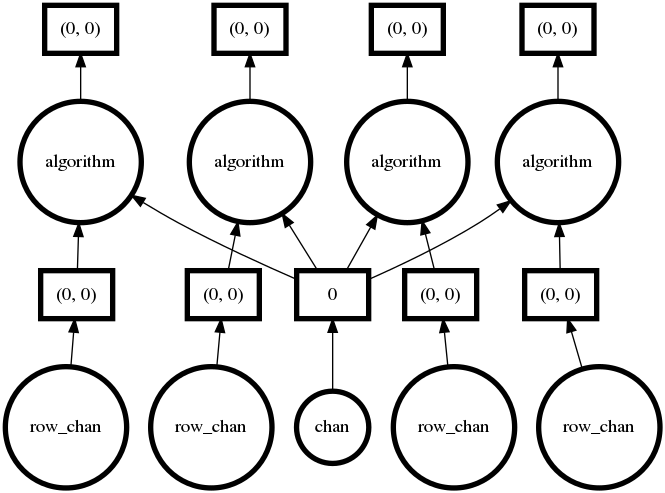

In [14]:
visualize_graph(example2)

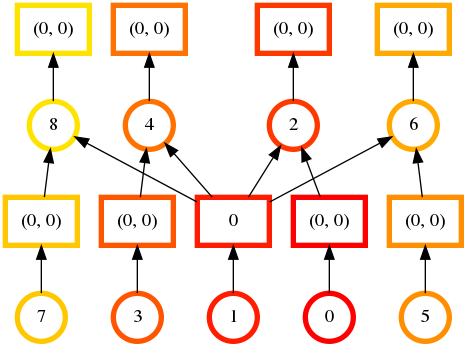

In [15]:
visualize_order(example2)

# Reductions

In [16]:
def reduction(nrow, nchan, row_chunks, chan_chunks): 

    row_chan_array = da.zeros((nrow, nchan),
                              chunks=(row_chunks, chan_chunks),
                              name="row-chan-" + uuid4().hex)

    def sum_chunk(x, axis, keepdims):
        return np.sum(x, axis, keepdims=keepdims)

    def sum_sums(x, axis, keepdims):
        return np.sum(x, axis, keepdims=keepdims)

    def sum_final(x, axis, keepdims):
        return np.sum(x, axis, keepdims=keepdims)

    result_arr = da.reduction(row_chan_array,
                              sum_chunk,
                              sum_final,
                              combine=sum_sums,
                              dtype=np.float64)
    
    return result_arr

In [17]:
example3 = reduction(10000, 64, 2500, 64)

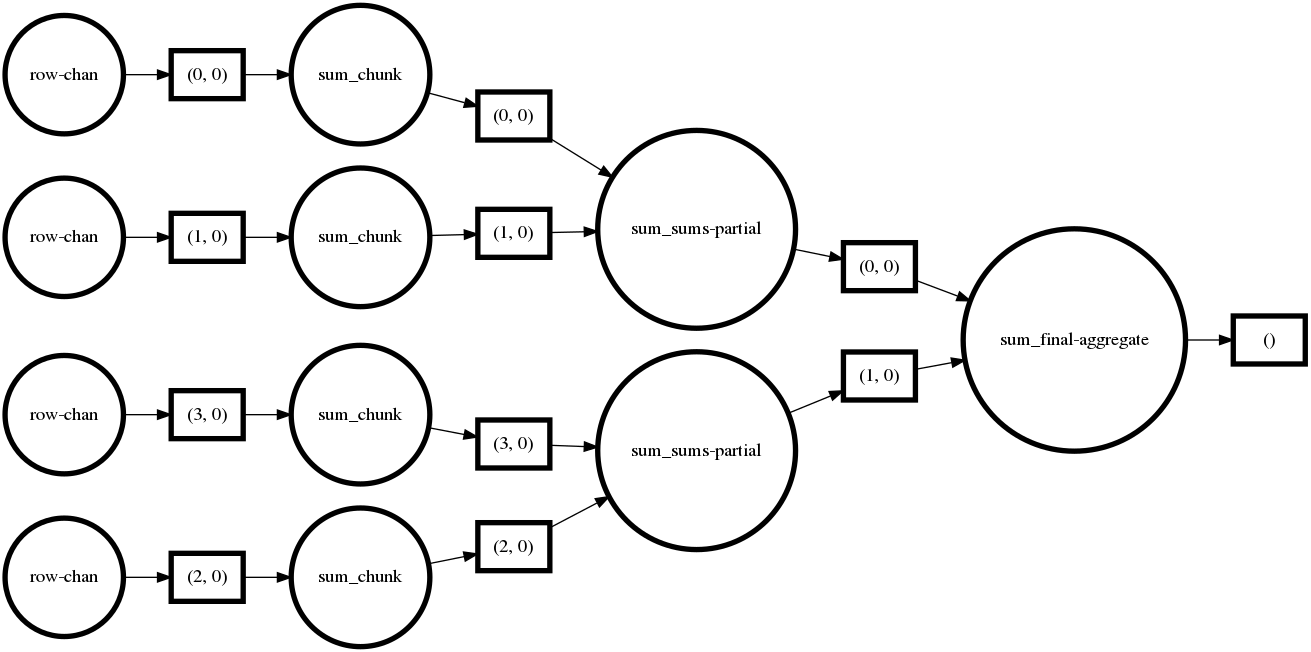

In [18]:
visualize_graph(example3, rankdir="LR")

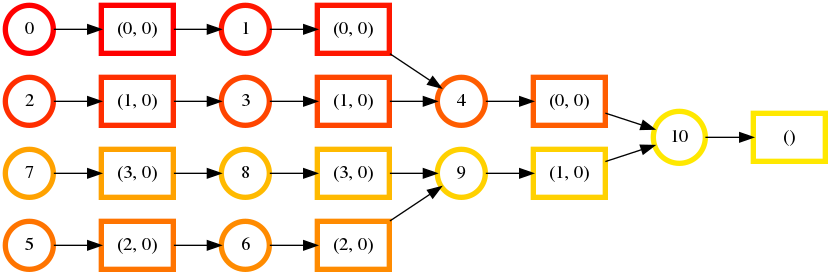

In [19]:
visualize_order(example3, rankdir="LR")

<a id='nocloning'></a>
# Real-world example - QuartiCal predict (provided by codex-africanus)
Compare with the [version post cloning](#cloning).

In [20]:
IFrame("./visualize_outputs/predict_graph.pdf", width=1720, height=800)

In [21]:
IFrame("./visualize_outputs/predict_order.pdf", width=1720, height=850)

# Ordering Issues - QuartiCal predict and calibrate

The following example was run using a LocalCluster with one worker running six threads.

In [22]:
IFrame(src='./no-cloning.html', width=1700, height=600)

In [37]:
IFrame(src="https://slides.com/jskenyon/deck-8a1a0e/embed#/9", width=1700, height=800)

<a id='clonedroots'></a>
# Graph Manipulation - Cloning
Compare with the [version without cloning](#sharedroots).

In [24]:
def cloned_root(nrow, nchan, row_chunks, chan_chunks, narray): 

    result_list = []
   
    chan_arr = da.zeros(nchan,
                        name="chan-" + uuid4().hex,
                        chunks=chan_chunks)

    for i in range(narray):
        row_chan_arr = da.zeros((nrow, nchan),
                                chunks=(row_chunks, chan_chunks),
                                name="row_chan-" + uuid4().hex)

        result_arr = da.blockwise(lambda x, y: x*y[None, :], "tf",
                                  row_chan_arr, "tf",
                                  clone(chan_arr), "f",  # The only change!
                                  dtype=np.float64,
                                  concatenate=True,
                                  align_arrays=False,
                                  name="algorithm-" + uuid4().hex)
        
        result_list.append(result_arr)
    
    return result_list

In [25]:
example4 = cloned_root(10000, 64, 10000, 64, 4)

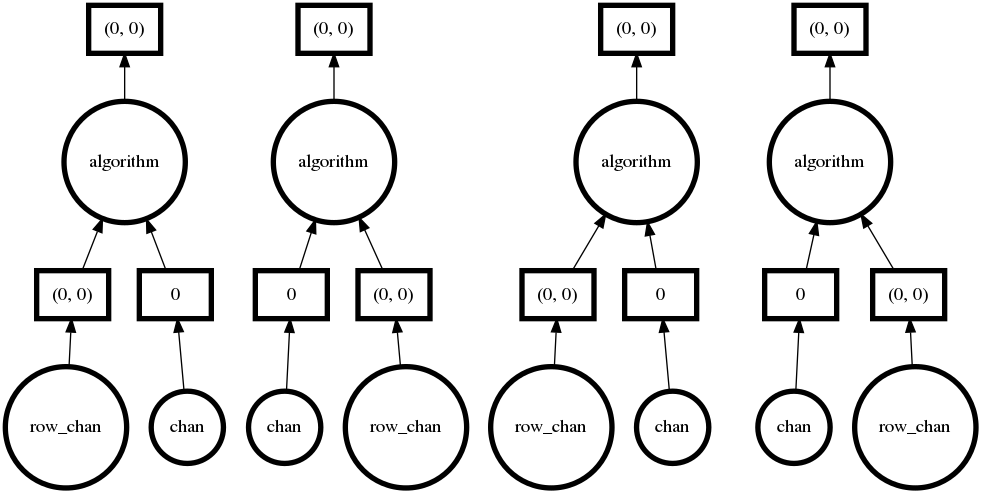

In [26]:
visualize_graph(example4)

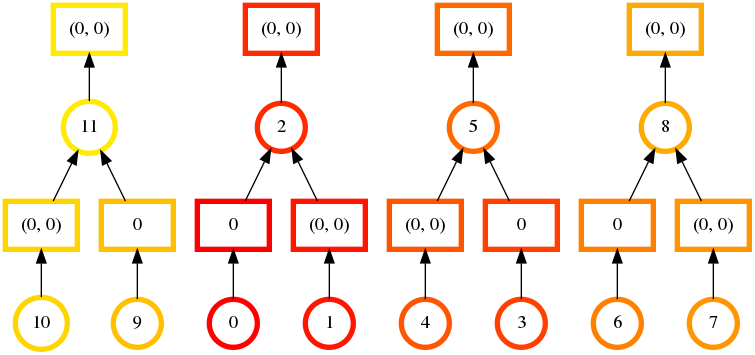

In [27]:
visualize_order(example4)

<a id='cloning'></a>
# Real-world example - QuartiCal predict (provided by codex-africanus) with cloning

Compare with the [version prior to cloning](#nocloning).

In [28]:
IFrame("./visualize_outputs/cloning_graph.pdf", width=1720, height=350)

In [29]:
IFrame("./visualize_outputs/cloning_order.pdf", width=1720, height=420)

# Cloning can improve ordering - QuartiCal predict and calibrate

The following example was run using a LocalCluster with one worker running six threads.

In [30]:
IFrame(src='./cloning.html', width=1700, height=600)

<a id='noplugin'></a>
# Scheduling issues - Unnecessary transfers

The following example was run using a LocalCluster with six workers, each running a single thread. Compare with [version using the plugin](#plugin).

In [31]:
IFrame(src='./no-plugin.html', width=1700, height=600)

In [32]:
IFrame(src="https://slides.com/jskenyon/deck-8a1a0e/embed#/11", width=1700, height=800)

<a id='plugin'></a>
# Scheduling issues - plugin stops transfers and further improves ordering

The following example was run using a LocalCluster with six workers, each running a single thread. Compare with the [version not using the plugin](#noplugin).

In [33]:
IFrame(src='./plugin.html', width=1700, height=600)

# Real-world example - QuartiCal calibration on the CHPC, Cape Town, South Africa

The following example was run using a PBSCluster with four workers, each running twenty-four threads.

In [34]:
IFrame(src='./chpc-noplugin.html', width=1700, height=650)

# Real-world example - QuartiCal calibration on the South African CHPC with scheduler plugin

The following example was run using a PBSCluster with four workers, each running twenty-four threads.

In [35]:
IFrame(src='./chpc.html', width=1700, height=650)

In [36]:
IFrame(src="https://slides.com/jskenyon/deck-8a1a0e/embed#/13", width=1700, height=800)